<a href="https://colab.research.google.com/github/andriyishynoleksandra/time-series-forecasting-lstm/blob/main/time_series_forecasting_lstm_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

# Завантаження даних
url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv"
df = pd.read_csv(url)
df.set_index('Month', inplace=True)
display(df.head())

,Passengers
Month,
1949-01,112
1949-02,118
1949-03,132
1949-04,129
1949-05,121


Створюю змінну типу `numpy.ndarray`, яка містить значення кількості пасажирів в форматі `float32`. Такий формат даних нам треба для тренування нейромережі.

In [2]:
df_new = np.array(df["Passengers"], dtype=np.float32)


In [3]:
df_new

array([112., 118., 132., 129., 121., 135., 148., 148., 136., 119., 104.,
       118., 115., 126., 141., 135., 125., 149., 170., 170., 158., 133.,
       114., 140., 145., 150., 178., 163., 172., 178., 199., 199., 184.,
       162., 146., 166., 171., 180., 193., 181., 183., 218., 230., 242.,
       209., 191., 172., 194., 196., 196., 236., 235., 229., 243., 264.,
       272., 237., 211., 180., 201., 204., 188., 235., 227., 234., 264.,
       302., 293., 259., 229., 203., 229., 242., 233., 267., 269., 270.,
       315., 364., 347., 312., 274., 237., 278., 284., 277., 317., 313.,
       318., 374., 413., 405., 355., 306., 271., 306., 315., 301., 356.,
       348., 355., 422., 465., 467., 404., 347., 305., 336., 340., 318.,
       362., 348., 363., 435., 491., 505., 404., 359., 310., 337., 360.,
       342., 406., 396., 420., 472., 548., 559., 463., 407., 362., 405.,
       417., 391., 419., 461., 472., 535., 622., 606., 508., 461., 390.,
       432.], dtype=float32)

Розбиваю дані на тренувальні і валідаційні у співвідношенні 67% йде у тренування, 33 - у валідацію. Так як ми працюємо з tim series, відповідно, навчаємось на давніших, валідуємось - на новіших.

In [ ]:
n = len(df_new)

train_size = int(n * 0.67)

train = df_new[:train_size]
val = df_new[train_size:]
train[:5].flatten()

array([112., 118., 132., 129., 121.], dtype=float32)

Створюю  функцію `create_dataset`, яка перетворить одномірний часовий ряд (набір даних) у формат, придатний для тренування нейромережі.

Функція  приймає два аргументи:
- `dataset` — numpy-масив часового ряду,
- `lookback` — кількість попередніх кроків, які використовуватимуться для передбачення.

Функція  поветає два **тензори** PyTorch:
- `X` — набір ознак (вікно попередніх значень),
- `y` — цільові значення (наступні після вікна кроки).



In [ ]:
import torch

def create_dataset(dataset, lookback=1):
    if isinstance(dataset, torch.Tensor):
        data = dataset.detach().cpu().numpy()
    else:
        data = np.asarray(dataset, dtype=np.float32)

    X, y = [], []
    for i in range(len(data) - lookback):
        X.append(data[i:i+lookback])
        y.append([data[i + lookback]])

    X = torch.tensor(X, dtype=torch.float32)
    y = torch.tensor(y, dtype=torch.float32)
    return X, y


In [ ]:
lookback = 1
X_train, y_train = create_dataset(train, lookback=lookback)
X_test, y_test = create_dataset(val, lookback=lookback)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

torch.Size([95, 1]) torch.Size([95, 1])
torch.Size([47, 1]) torch.Size([47, 1])


 Наступним кроком створюю об'єкт класу `AirModel` зі значеннями параметрів `hidden_size=50`, `num_layers=1` і протестую роботу моделі на вхідному тензорі `tensor([[112.]])`. На цьому етапі ми маємо переконатись, що модель здатна генерувати передбачення з рандомно ініційованими вагами.

In [ ]:
import torch.nn as nn

class AirModel(nn.Module):
    def __init__(self, hidden_size, num_layers):
        super(AirModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.lstm = nn.LSTM(
            input_size=1,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True
        )

        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        x = x.unsqueeze(1)

        lstm_out, _ = self.lstm(x)
        out = lstm_out[:, -1, :]
        out = self.fc(out)

        return out


In [ ]:
model = AirModel(hidden_size=50, num_layers=1)
x_test = torch.tensor([[112.]], dtype=torch.float32)
y_pred = model(x_test)
y_pred

tensor([[0.3621]], grad_fn=<AddmmBackward0>)

Далі створюємо об'єкт DataLoader для завантаження даних, використовуючи тренувальні вибірки `X_train` та `y_train`

In [ ]:
from torch.utils.data import TensorDataset, DataLoader
train_dataset = TensorDataset(X_train, y_train)

train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=8,
    shuffle=True
)
for X_batch, y_batch in train_loader:
    print("X_batch shape:", X_batch.shape)
    print("y_batch shape:", y_batch.shape)
    break


X_batch shape: torch.Size([8, 1])
y_batch shape: torch.Size([8, 1])


Наступний крок  - навчання нейронної мережі `AirModel` для прогнозування часових рядів, використовуючи Adam-оптимізатор та функцію втрат MSE (середньоквадратичну похибку).
1.  цикл тренування для 2000 епох, у якому на кожній епосі: (прямий прохід, обчислення похибки, зворотний прохід і оновлення ваг).
2. обчислимо середню похибку на кожному батчі даних і зберігаємо її у списку `losses`.
3. Раз на 100 епох проводимо валідацію моделі, а саме перевіряємо модель на тренувальних та тестових даних без оновлення ваг та бчислюємо корінь середньоквадратичної похибки (RMSE) для тренувальної та тестової вибірок
   

In [ ]:

epochs = 2000
learning_rate = 0.001

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

losses = []

for epoch in range(epochs):
    model.train()
    epoch_loss = 0.0

    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    avg_loss = epoch_loss / len(train_loader)
    losses.append(avg_loss)

    if (epoch + 1) % 100 == 0:
        model.eval()
        with torch.no_grad():
            train_pred = model(X_train)
            train_rmse = torch.sqrt(criterion(train_pred, y_train)).item()

            test_pred = model(X_test)
            test_rmse = torch.sqrt(criterion(test_pred, y_test)).item()

        print(f"Епоха [{epoch+1}/{epochs}] | "
              f"Train Loss: {avg_loss:.6f} | "
              f"Train RMSE: {train_rmse:.3f} | "
              f"Test RMSE: {test_rmse:.3f}")


Епоха [100/2000] | Train Loss: 34082.220215 | Train RMSE: 184.888 | Test RMSE: 379.370
Епоха [200/2000] | Train Loss: 23010.033040 | Train RMSE: 151.733 | Test RMSE: 343.586
Епоха [300/2000] | Train Loss: 15124.811361 | Train RMSE: 122.879 | Test RMSE: 310.710
Епоха [400/2000] | Train Loss: 9877.111043 | Train RMSE: 99.544 | Test RMSE: 281.203
Епоха [500/2000] | Train Loss: 6679.945989 | Train RMSE: 81.243 | Test RMSE: 254.793
Епоха [600/2000] | Train Loss: 4234.277476 | Train RMSE: 65.115 | Test RMSE: 229.506
Епоха [700/2000] | Train Loss: 2817.300039 | Train RMSE: 53.079 | Test RMSE: 206.354
Епоха [800/2000] | Train Loss: 1872.340429 | Train RMSE: 43.156 | Test RMSE: 185.762
Епоха [900/2000] | Train Loss: 1334.224414 | Train RMSE: 36.413 | Test RMSE: 167.647
Епоха [1000/2000] | Train Loss: 1034.995232 | Train RMSE: 31.913 | Test RMSE: 152.280
Епоха [1100/2000] | Train Loss: 835.673136 | Train RMSE: 28.580 | Test RMSE: 139.159
Епоха [1200/2000] | Train Loss: 789.493872 | Train RMSE: 2

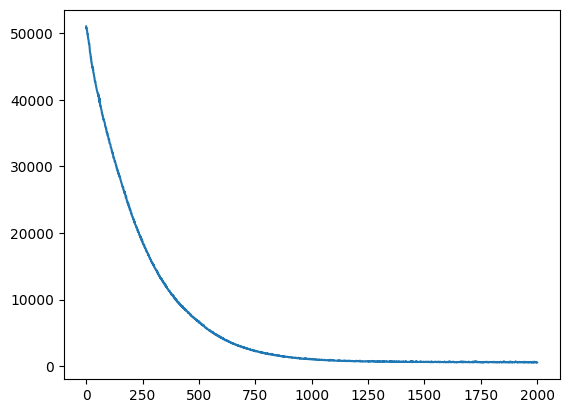

In [ ]:
import matplotlib.pyplot as plt
plt.plot(losses);

Модель навчилась, але не факт, що точно)

Доволі неочікувано, що середньоквадратичне відхилення тестового набору даних буде на порядок більшим за одиниці в нашому наборі даних. Середньоквадратичне відхилення 100 означає, що прогноз і фактичне значення будуть відрізнятися в середньому на 100 (тобто, 100 000 пасажирів у цьому наборі даних).



Щоб краще зрозуміти якість прогнозу, побудуємо графік з кодом нижче

In [ ]:
timeseries = df_new.flatten()

/tmp/ipython-input-311553601.py:7: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  train_plot[lookback:train_size] = model(X_train)[:, -1]
/tmp/ipython-input-311553601.py:11: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  test_plot[train_size+lookback:len(timeseries)] = model(X_test)[:, -1]


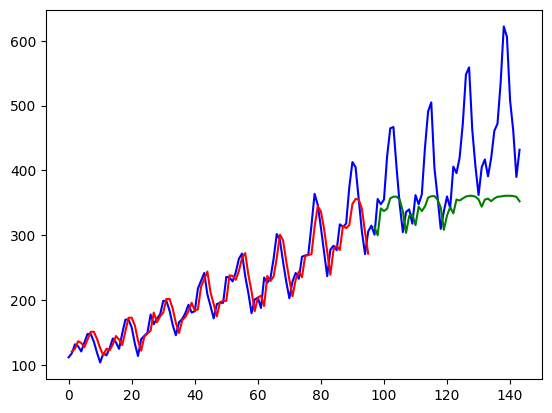

In [ ]:
def plot_predicts():
  with torch.no_grad():
      # Зсув прогнозів для тренувальних даних
      train_plot = np.ones_like(timeseries) * np.nan
      y_pred = model(X_train)
      y_pred = y_pred[:, -1]
      train_plot[lookback:train_size] = model(X_train)[:, -1]

      # Зсув прогнозів для тестових даних
      test_plot = np.ones_like(timeseries) * np.nan
      test_plot[train_size+lookback:len(timeseries)] = model(X_test)[:, -1]

  # Візуалізація результатів
  plt.plot(timeseries, c='b')  # Реальні дані
  plt.plot(train_plot, c='r')  # Прогнози на тренувальних даних
  plt.plot(test_plot, c='g')   # Прогнози на тестових даних
  plt.show()

plot_predicts()

**Що відбувається в коді вище.** В цьому коді здійснюється процес прогнозування часових рядів за допомогою LSTM моделі, а також виведення графіку, який показує реальні значення, тренувальні та тестові прогнози. Ось що відбувається на кожному етапі:

1. **`torch.no_grad()`**: Цей контекстний менеджер вимикає обчислення градієнтів, що означає, що під час прогнозування не будуть зберігатися проміжні обчислення для зворотного проходу (backpropagation). Це підвищує ефективність під час прогнозування і зменшує використання пам'яті.

2. **Зсув прогнозів для тренувальних даних:**
   - Створюється масив `train_plot`, який має такий самий розмір, як і часовий ряд (`timeseries`), і заповнюється значеннями NaN (`np.nan`), щоб залишити місце для реальних значень.
   - Модель передбачає виходи для тренувальних даних `X_train`.
   - Використовується лише останнє передбачене значення для кожного входу LSTM (`y_pred[:, -1]`).
   - Прогнози зсуваються, починаючи з індексу `lookback` до кінця тренувальних даних (індекс `train_size`). Цей зсув потрібен, щоб зробити прогноз на основі попередніх даних і відобразити його на правильній частині графіку.

3. **Зсув прогнозів для тестових даних:**
   - Створюється масив `test_plot`, який також заповнюється NaN.
   - Прогнози для тестових даних додаються з індексу `train_size + lookback` до кінця реальних даних, щоб відобразити, де модель починає прогнозувати тестову вибірку.

4. **Побудова графіка:**
   - `plt.plot(timeseries, c='b')`: Виводить реальні значення часового ряду (синя лінія).
   - `plt.plot(train_plot, c='r')`: Виводить тренувальні прогнози (червона лінія).
   - `plt.plot(test_plot, c='g')`: Виводить тестові прогнози (зелена лінія).

**Чому це робиться:**
- Зсув прогнозів для тренувальних і тестових даних дозволяє візуально зрівняти, наскільки добре модель прогнозує як на тренувальній, так і на тестовій вибірках. Зазвичай, червона лінія (тренувальні прогнози) повинна точно відповідати синій лінії (реальні дані), а зелена лінія (тестові прогнози) дає змогу побачити, наскільки модель добре працює на нових даних, яких вона раніше не бачила.

Спробуємо навчити модель з hidden_size=100 та порівняємо  результати прогнозів з попередніми.

In [ ]:
model = AirModel(hidden_size=50, num_layers=1)


Епоха [100/2000] | Train Loss: 33320.472575 | Train RMSE: 182.189 | Test RMSE: 376.504
Епоха [200/2000] | Train Loss: 21692.287842 | Train RMSE: 147.035 | Test RMSE: 338.381
Епоха [300/2000] | Train Loss: 13871.364583 | Train RMSE: 117.545 | Test RMSE: 304.302
Епоха [400/2000] | Train Loss: 8955.327433 | Train RMSE: 94.505 | Test RMSE: 274.096
Епоха [500/2000] | Train Loss: 5781.455027 | Train RMSE: 75.857 | Test RMSE: 246.808
Епоха [600/2000] | Train Loss: 3627.880925 | Train RMSE: 60.041 | Test RMSE: 220.869
Епоха [700/2000] | Train Loss: 2328.617079 | Train RMSE: 48.286 | Test RMSE: 197.769
Епоха [800/2000] | Train Loss: 1586.956439 | Train RMSE: 39.591 | Test RMSE: 177.388
Епоха [900/2000] | Train Loss: 1159.607376 | Train RMSE: 33.757 | Test RMSE: 159.615
Епоха [1000/2000] | Train Loss: 968.070730 | Train RMSE: 30.530 | Test RMSE: 145.361
Епоха [1100/2000] | Train Loss: 774.428923 | Train RMSE: 27.234 | Test RMSE: 133.154
Епоха [1200/2000] | Train Loss: 673.452052 | Train RMSE: 26

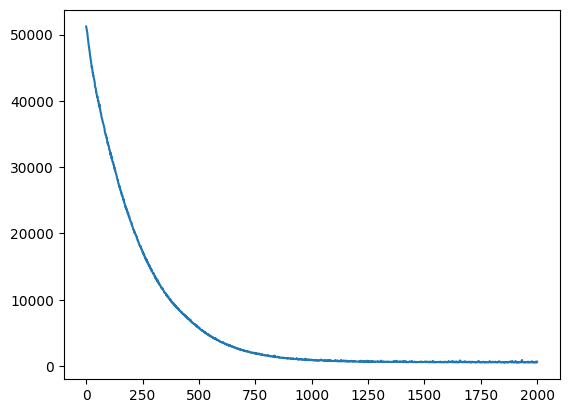

In [ ]:
plt.plot(losses);

Обидві моделі демонструють дуже схожу динаміку зменшення Train Loss:

Початкові втрати (≈33–34 тис.) — практично однакові

Падіння Train Loss по епохах — майже ідентичне

Фінальний Train Loss:

* hidden=50: ~553

* hidden=100: ~551

Висновок: збільшення hidden_size не дає значного виграшу у якості навчання на train set.